# Portfolio
This notebook uses the Sharpe Ration to optimize a portfolio weights and then models the portfolio based off of these weights.
The notebook completes this using the following steps:
1. Gather histrorical data
2. Calculate the Sharpe Ratio
3. Maximize the Sharpe Ratio
4. Model with weights

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import yfinance as yf
import math as m
from scipy.stats import norm
from scipy.optimize import minimize

# Risk Free Weight
First we need to get the risk free rate. This can be found on the federal website: https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value=2025. Please pick the right rate for how long you want to model for. 

In [2]:
total = 3 * 365
r = 3.7/100
port = ['MSFT','NVDA','TSM','MRK','UPS','JNJ','KO'] #['MS','MSFT','GOOG','JPM'] #['TSLA','GME'] #['AAPL','MSFT','GOOG','AMZN','META']

# Gathering Data
The following functions gather data for the different stocks and calculates the daily Percent Change as well as the daily Log Percent Change. I keep the data in a dictionary for easy seperation and fast reference. 

There is also a random weight generating function. This makes a number of random weights and normalizes them to make sure all of the set of weights sums equals 1. 

In [3]:
def get_data(tickers : list, days = total):
    '''Inputs: tickers -> list of stocks for portfolio ; days -> amount for stock's history.
    Returns a dictionary of the stocks with the necessary data for Monte Carlo Simulations'''
    end = dict()
    closes = dict()
    date_start = dt.date.today() - dt.timedelta(days = days)
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        data = stock.history(start = date_start)
        data = data.drop(columns=['Volume','Dividends','Stock Splits','Open','High','Low']) 
        data["Percent Change"] = data["Close"].pct_change() 
        data["Log Change"] = np.log(data['Percent Change'] + 1)
        end[ticker] = data
        closes[ticker] = data['Close'][-1]
    return end, closes

def df_log_changes(data: dict):
    end = pd.DataFrame(index=data[list(data.keys())[0]].index)
    for ticker in data:
        end[ticker] = data[ticker]['Log Change']
    return end

def random_weights(assets:int, num = 10000):
    end = np.random.uniform(0,1,size=(num,assets))
    sums = np.sum(end,axis=1)
    end = end / sums[:,np.newaxis] #scale for sum of each to be equal to 1
    return end


# Important Funtions
The next cell defines many important funtions. 
## Portfolio Geometric Brownian Motion
This function is what models the portfolio based off of weights. 
The function starts by gathering the daily log changes for each stock. These daily log changes are then put in a dataframe, which allows us to then get the mean of the log changes and the Covariance Matrix ($K$) of the log changes. From here, we can get the Cholesky decomposition of the Covariance Matrix. The Cholesky decomposition is a lower-triangular matrix such that $L L^T = K$, where $L$ is the Cholesky decomposition. In other words, a Cholesky decomposition matrix multiplied by it's own transpose results in the origional covariance matrix. We then make a mean matrix $\hat{\mu}$, where each rows is the mean for each stock, repeated for each of the future days. So $\hat{\mu}$ is a $\text{Number of Stocks x Number of Future Days}$ sized matrix.


Next, we run the simulations. We start by taking samples for each days as if each stock operates as a independent standard normal distribution. We call this matrix $\hat{Z}$.

We then perform $L \hat{Z}^T$, which gives us a matix of size $\text{Number of Stocks x Number of Future Days}$. This action brings covariance to the independent standard normal distributions. We then add this result on to the mean matrix $\hat{\mu}$. This makes it so are samples are from a mulivariate normal distribution with mean vector $\hat{\mu}$ and covariance vector $K$. We shall call this addition of the mean matirx and the $L \hat{Z}^T$ the returns matrix.  

Then, we take the product of the weights row vector, which is of size $1 x number stocks$ and the returns matrix, which gives a row vector of size $1 x Number of Future Days$. We laslty add one to all of the values of this row vector, take the cumulative product to get the change from the beginning to that days as factor, and mulitply it to the intial price. This gives us our model.

## Portolio Expected Volatility
Let $\hat{\lambda}$ be a vector of the expected daily returns for the stocks, and $\hat{w}$ be the weights for the stocks. 
This function takes in a weights array, an array of the of the mean daily changes, and the covariance matrix. The expected return of the portfolio is calculated. This is given by $\sum_{i = 1}^{n} \hat{\lambda}_i \hat{w}_i$ which is the dot product of $\hat{\lambda}$ and $\hat{w}$.

The volatility of the portfolio is as follows $\sqrt{\hat{w}^T K \hat{w}}$ which is a scalar value. 

If the weighs is a matix of many sets of weights, then the function does these two for each set of weights. 

## Average Returns
Returns the yearly average returns of each stock. 

In [4]:
def Port_GBM(data: dict, weights: np.ndarray, num = 10000, days = 252, intiial_value = 1000):
    percent_changes_df = pd.DataFrame(index=data[list(data.keys())[0]].index)
    for ticker in data:
        percent_changes_df[ticker] = data[ticker]['Log Change'] #data[ticker]['Percent Change']
    
    means = percent_changes_df.mean()
    covMatrix = percent_changes_df.cov()
    cholesky = np.linalg.cholesky(covMatrix)
    
    meansMatrix = np.full(shape=(days,len(weights)),fill_value=means).T

    end = np.full(shape=(days + 1, num), fill_value= 0.0)
    end[0] = intiial_value

    for i in range(num):
        normal = np.random.normal(size = (days , len(weights)))
        returns = meansMatrix + cholesky @ normal.T
        end[1:,i] = np.cumprod(weights @ returns + 1) * intiial_value

    return pd.DataFrame(end)

def port_exp_vol(weights: np.ndarray, expected_array : np.ndarray, covariance: np.ndarray):
    expected = np.sum(weights * expected_array, axis= 1) #sum weight * expected_hist_return
    vols = []
    for i in range(len(weights)):
        vols.append(weights[i].T @ covariance @ weights[i])
    return expected, np.sqrt(np.array(vols))

def avg_returns(log_changes: pd.DataFrame):
    '''Gives YEARLY historical expected returns. Given by daily expected * 252'''
    end = dict()
    for ticker in log_changes.columns.tolist():
        end[ticker] = np.mean(log_changes[ticker]) * 252
    return end

# Sharpe Ratio Functions
The Sharpe Ratio is defined as the $\frac{\text{Expected Return} - r}{\text{Expected Volatility}}$ where $r$ is the risk free rate.

This is essentially a measure of expected return over expected volatility. The higher the ration, the better the reward with less risk. 
## Maxamine and Minimun Sharpe Ration
Calculated the Sharpe Ratio for each set of weights. The function then founds the weights from the weights array that maximize and minimize the ratio. This is a Monte Carlo simulation to find the best weights, as thousands of different weight sets were generated. 

## Sum One
Makes sure the weights add up to one, used in a later scipy minimize function use. 

## Sharpe Ratio Negative
Return the negative of the Sharpe Ration so scipy minimize can find the weights to maximize the ratio.

## Plot Frontier 
Plots all of the randomly genearated weights Sharpe Ratio. Volatility is on the X-axis and Expected Return is on the Y-axis. The color is based off the Sharpe Ratio itself.

In [5]:
def Sharpe_ratio_negative(weights, expected, covariance, R = r):
    expected = np.sum(weights * expected) #sum weight * expected_hist_return
    vol = np.sqrt(weights.T @ covariance @ weights)
    ratio = (expected - R) / vol
    return -ratio

def max_min_sharpe(weights, expected, vol, R = r):
    sharpe = (expected - R) / vol
    max_sharpe = np.argmax(sharpe)
    max_weights = weights[max_sharpe]
    min_sharpe = np.argmin(sharpe)
    min_weighs = weights[min_sharpe]
    return max_weights, min_weighs

def sum_one(weights):
    return np.sum(weights) - 1

def plot_frontier(expected_returns: np.ndarray, volatilities: np.ndarray, R = r):
    plt.figure(figsize=(10, 6))
    plt.scatter(volatilities, expected_returns, c = (expected_returns - R) / volatilities)
    plt.title('Portfolio Frontier')
    plt.xlabel('Portfolio Volatility')
    plt.ylabel('Portfolio Expected Return')
    plt.colorbar(label = 'Sharpe Ratio')
    plt.grid(True)
    plt.show()

In [6]:
def ProbabilityOver(results,initial):
    np.array(initial)
    initial = round(initial,2)
    print(f"Probabilty over initial value ({initial}) by count: {np.count_nonzero(results > initial)/len(results)}")

def VaR_CVaR(results: pd.Series, intial: float, r : float = 10):
    value_r = round(np.percentile(results,r),2)
    

    mean_r = round(np.mean([x for x in results if x <= value_r]),2)

    print('\n')
    print(f'Value at which {r}% of predictions fall under by results: {value_r}')
    print(f'Expected price of lower {r}%: {mean_r}')
    if mean_r - intial < 0:
        print(f'Expected loss: {round(abs(mean_r - intial),2)}') #E[X - last_close] = E[X] - last_close, where X is the resuults under VaR
    else:
        print(f'Expected gain: {round(abs(mean_r - intial),2)}')

# Gathering Data
Here we begin to gather data and set up the dataframes as needed. We also make the covariance matrix, the covariance matrix for our time of modeling or the life of the portfolio, and calculate the yearly expected return for each stock. Lastly, we then generate 10,000 random weights for the portfolio. 

In [7]:
days = 252
data, closes = get_data(port)
log_changes = df_log_changes(data)
covariance = log_changes.cov()
days_cov = covariance * days
year_expected = avg_returns(log_changes)
year_expected_array = [year_expected[ticker] for ticker in year_expected]
weights = random_weights(len(port))

# Sharpe Ratio Frontier
First, the expected return and volatility is calculated for each set of weights. Then the Sharpe Ratios are graphed.
The graph often makes a large curve that looks similar to a boomerang. To get the maximum ratio, one should take from the part of the graph right above where the curve is the sharpest. This makes sure are expected return is respectful, without a ton of risk. 

Lastly, we found the set of weights that maximizes and minimizes the Sharpe Ratio using our many randomized weights. 

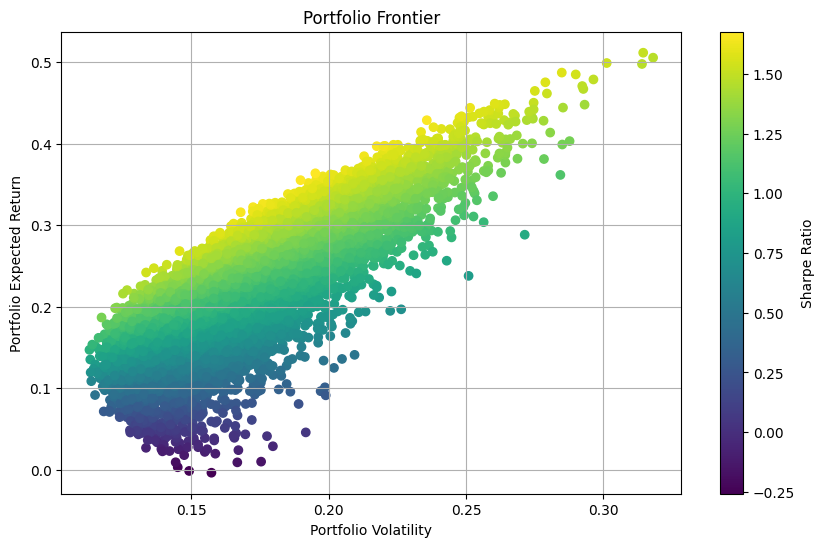

In [8]:
expected_return, vol = port_exp_vol(weights,year_expected_array,days_cov)
plot_frontier(expected_return,vol)
max_sharpe, min_sharpe = max_min_sharpe(weights,expected_return,vol)

# Scipy Minimize
Utilizes Scipy Minimize to get the weights that maximize the Sharpe Ratio. 

In [9]:
best = minimize(Sharpe_ratio_negative,np.array([1/len(port)] * len(port)),args= (year_expected_array,days_cov,r),method='SLSQP',bounds=((0,1),)*len(port), constraints= ({'type':'eq','fun':sum_one}))

# Reporting The Min,Max Weights
The following reports the weight set that produces the minumum Sharpe Ratio via the randomly generated rates. This also reports the weight sets the maximize the Sharpe Ratio using the randomized weights and the Scipy Minimize Function.

In [10]:
print(f'Monte Carlo Max Sharpe Ratio weights:')
for i in range(len(port)):
    print(f'{port[i]}: {round(100 * max_sharpe[i],2)}')
print(f'with a ratio of {-Sharpe_ratio_negative(max_sharpe,year_expected_array,days_cov)}')
print('\n')

print(f'Monte Carlo Min Sharpe Ratio weights:')
for i in range(len(port)):
    print(f'{port[i]}: {round(100 * min_sharpe[i],2)}')
print(f'with a ratio of {-Sharpe_ratio_negative(min_sharpe,year_expected_array,days_cov)}')

print('\n')
print(f'Minimize Max Sharpe Ratio weights:')
for i in range(len(port)):
    print(f'{port[i]}: {round(100 * best.x[i],2)}')
print(f'with a ratio of {-Sharpe_ratio_negative(best.x,year_expected_array,days_cov)}')
print('\n')

Monte Carlo Max Sharpe Ratio weights:
MSFT: 6.28
NVDA: 33.44
TSM: 4.36
MRK: 2.66
UPS: 1.09
JNJ: 20.05
KO: 32.1
with a ratio of 1.676751693099681


Monte Carlo Min Sharpe Ratio weights:
MSFT: 9.89
NVDA: 1.28
TSM: 1.01
MRK: 21.05
UPS: 39.08
JNJ: 22.27
KO: 5.41
with a ratio of -0.2575273130708698


Minimize Max Sharpe Ratio weights:
MSFT: 0.0
NVDA: 34.95
TSM: 6.17
MRK: 0.0
UPS: 0.0
JNJ: 25.83
KO: 33.05
with a ratio of 1.7183062953108992




# Modeling
First we get the intial price as the sum of the weight of each stock multiplied by the closing price of that stock. 

Then, we model the stock using the Portfolio Geometric Brownian Motion function as defined earlier. 

In [11]:
intitial_price = sum(closes[ticker] * best.x[i] for i, ticker in enumerate(port))
port_sim = Port_GBM(data,best.x, intiial_value = intitial_price)

# Graphing
Here, we graph the individual paths of the portfolio over time, then we graph the results as a normalized histogram.

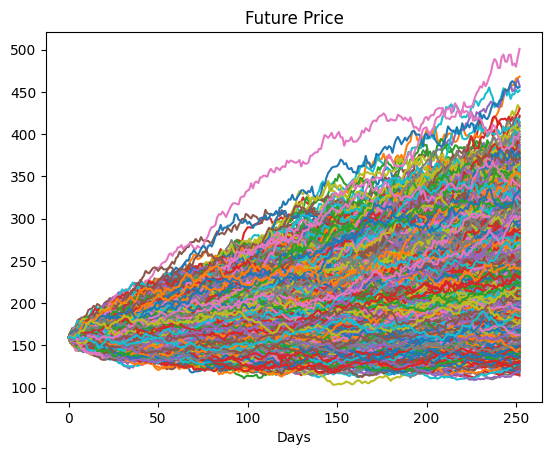

In [12]:
port_sim.plot(legend=False)
plt.title("Future Price")
plt.xlabel("Days")
plt.show()


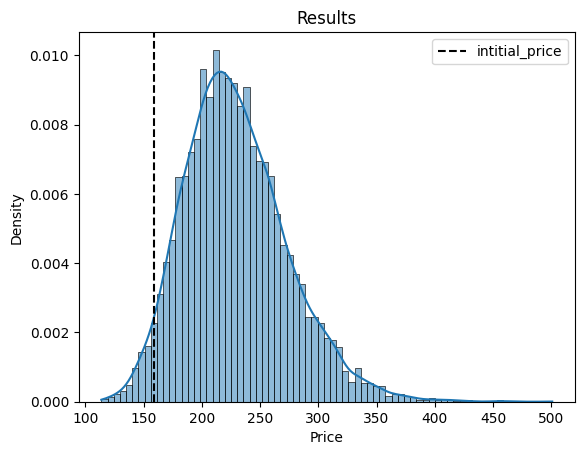

In [13]:
sns.histplot(np.array(np.array(port_sim.iloc[-1])), kde= True, bins='auto', stat='density')
plt.axvline(x = intitial_price, color = 'black', linestyle = '--', label = "intitial_price")
plt.title("Results")
plt.xlabel("Price")
plt.legend()
plt.show()

# Risk
Lastly, we found the probabiliy that the porfolio gains in value over the time of the model. Finally, we find the VaR and CVaR for a risk of 10%.

In [14]:
ProbabilityOver(port_sim.iloc[-1], intitial_price)
VaR_CVaR(port_sim.iloc[-1],intitial_price, 10)

Probabilty over initial value (159.21) by count: 0.9658


Value at which 10% of predictions fall under by results: 176.73
Expected price of lower 10%: 161.69
Expected gain: 2.48
